In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="6"

Sat Jan 27 00:52:08 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   52C    P0    84W / 300W |   8299MiB / 80994MiB |     22%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = True
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-3_hardquantize/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

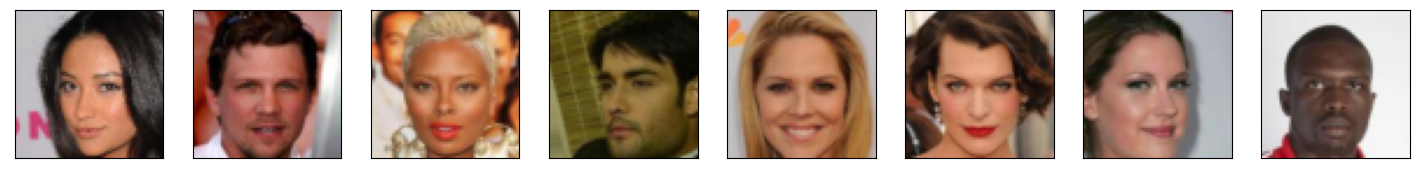

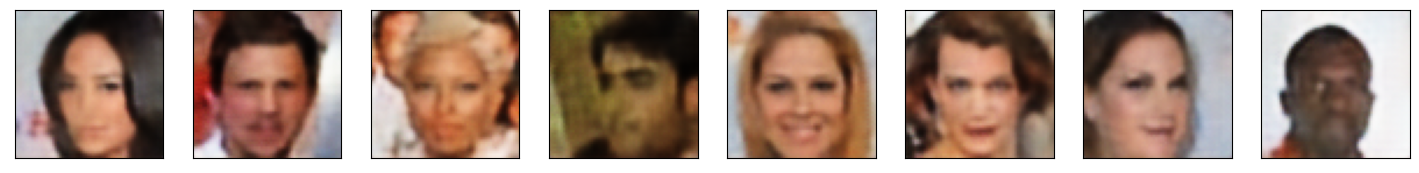

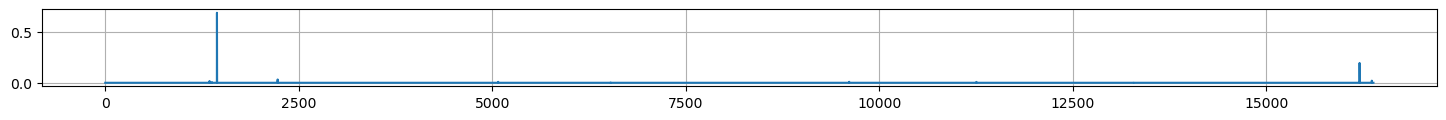

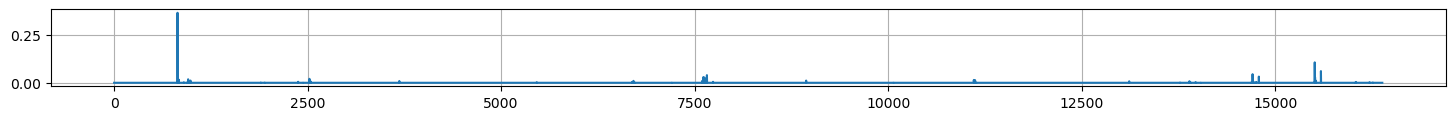

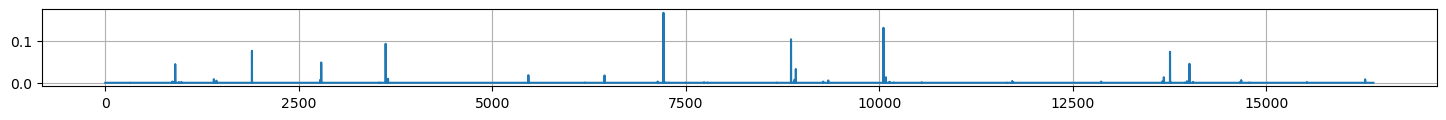

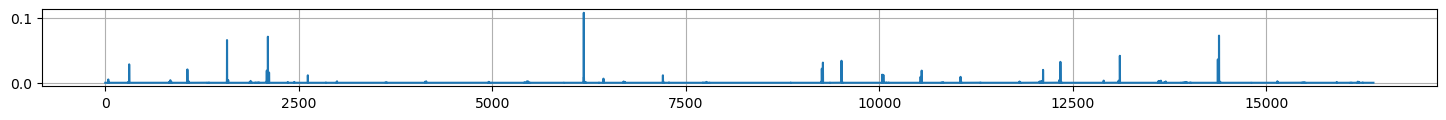

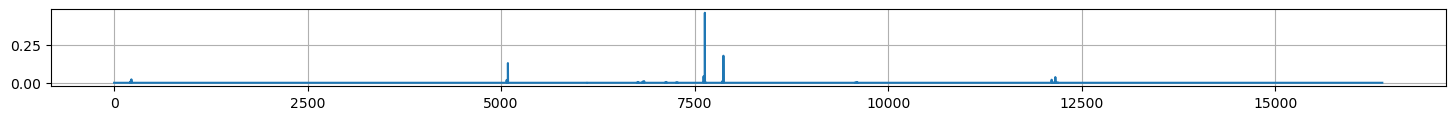

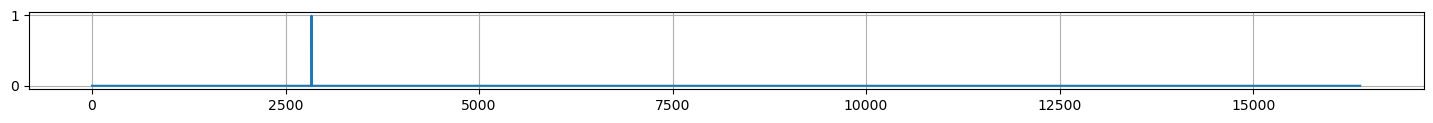

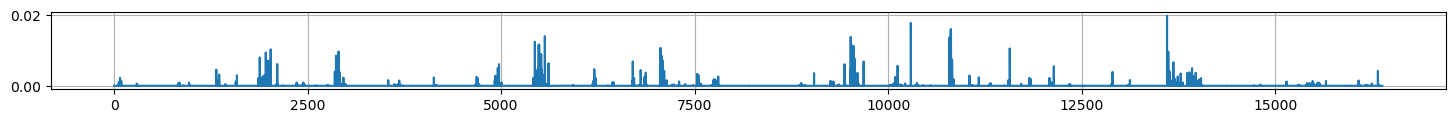

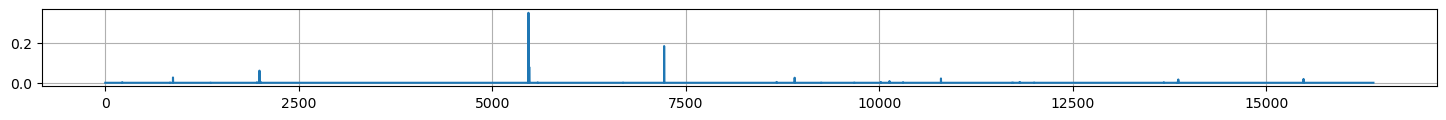

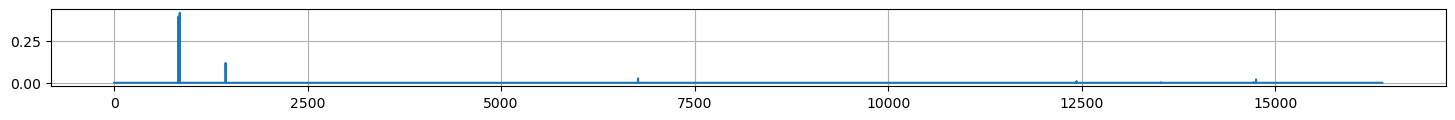

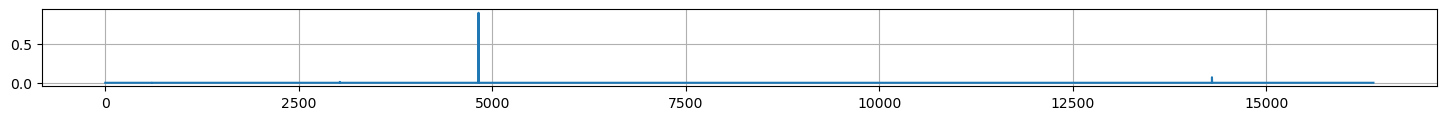

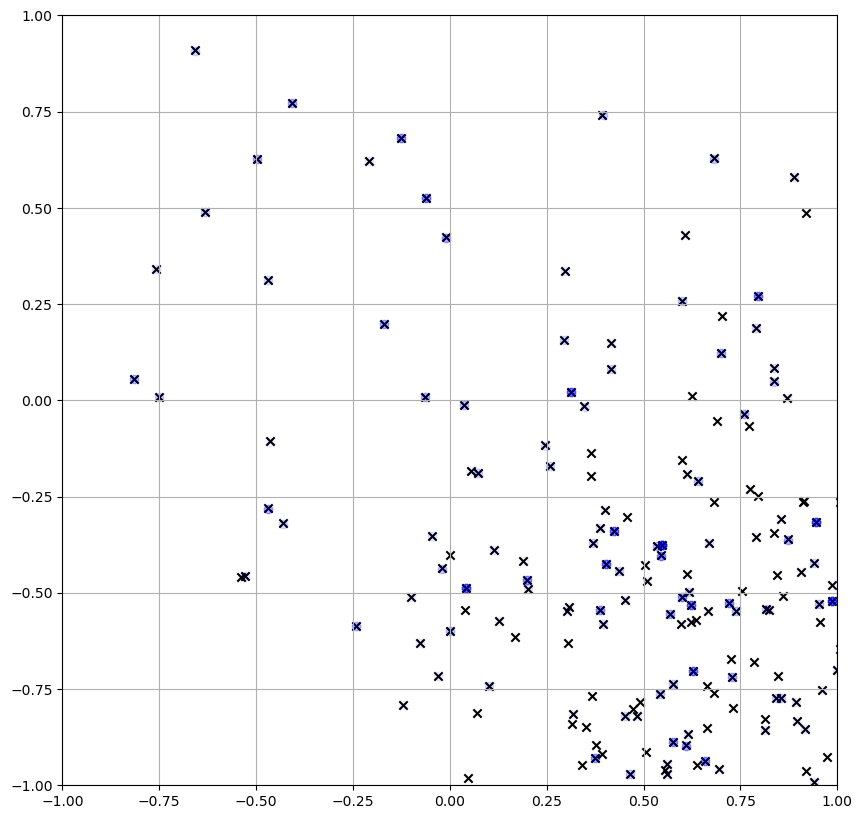

10001
lse_loss -85.24858856201172
commit_loss 0.07893243432044983
recon_loss 0.002981471596285701
10002
lse_loss -85.42568969726562
commit_loss 0.07568646967411041
recon_loss 0.002866010880097747
10003
lse_loss -85.4252700805664
commit_loss 0.07673061639070511
recon_loss 0.0029184757731854916
10004
lse_loss -85.30020904541016
commit_loss 0.08156859874725342
recon_loss 0.003106839722022414
10005
lse_loss -85.15340423583984
commit_loss 0.0796968936920166
recon_loss 0.003129430115222931
10006
lse_loss -85.26579284667969
commit_loss 0.0764082744717598
recon_loss 0.0027579236775636673
10007
lse_loss -85.25625610351562
commit_loss 0.0803392082452774
recon_loss 0.0029840085189789534
10008
lse_loss -85.41180419921875
commit_loss 0.07616358250379562
recon_loss 0.002799246460199356
10009
lse_loss -85.46399688720703
commit_loss 0.08068618178367615
recon_loss 0.002785279881209135
10010
lse_loss -85.26610565185547
commit_loss 0.08226929605007172
recon_loss 0.0036726321559399366
10011
lse_loss -85.3

10086
lse_loss -85.82255554199219
commit_loss 0.07769900560379028
recon_loss 0.002707905601710081
10087
lse_loss -85.73809051513672
commit_loss 0.0803321823477745
recon_loss 0.003203894477337599
10088
lse_loss -85.86245727539062
commit_loss 0.07897530496120453
recon_loss 0.0027726716361939907
10089
lse_loss -85.71989440917969
commit_loss 0.08038367331027985
recon_loss 0.002953607589006424
10090
lse_loss -85.83760833740234
commit_loss 0.08007501810789108
recon_loss 0.0029991562478244305
10091
lse_loss -86.00491333007812
commit_loss 0.07576075196266174
recon_loss 0.0027743575628846884
10092
lse_loss -85.84173583984375
commit_loss 0.07815554738044739
recon_loss 0.0030073365196585655
10093
lse_loss -85.96611022949219
commit_loss 0.07556815445423126
recon_loss 0.002774067921563983
10094
lse_loss -85.89937591552734
commit_loss 0.07721361517906189
recon_loss 0.0028424332849681377
10095
lse_loss -85.9324951171875
commit_loss 0.07556070387363434
recon_loss 0.0028052087873220444
10096
lse_loss -

lse_loss -86.3027572631836
commit_loss 0.08174282312393188
recon_loss 0.0031456060241907835
10172
lse_loss -86.20930480957031
commit_loss 0.07985887676477432
recon_loss 0.0031531709246337414
10173
lse_loss -86.46508026123047
commit_loss 0.07612888514995575
recon_loss 0.0030665562953799963
10174
lse_loss -86.42536926269531
commit_loss 0.07907523214817047
recon_loss 0.0029119092505425215
10175
lse_loss -84.17613983154297
commit_loss 0.08274272084236145
recon_loss 0.005068795755505562
10176
lse_loss -86.33647155761719
commit_loss 0.07573312520980835
recon_loss 0.0028707270976155996
10177
lse_loss -86.41372680664062
commit_loss 0.07738526165485382
recon_loss 0.0034119458869099617
10178
lse_loss -86.46684265136719
commit_loss 0.07783764600753784
recon_loss 0.0029482420068234205
10179
lse_loss -86.44768524169922
commit_loss 0.07638175785541534
recon_loss 0.0027676678728312254
10180
lse_loss -86.44651794433594
commit_loss 0.07493220269680023
recon_loss 0.002693314803764224
10181
lse_loss -86.

10256
lse_loss -86.99388122558594
commit_loss 0.07801777124404907
recon_loss 0.0032929189037531614
10257
lse_loss -87.02088928222656
commit_loss 0.07894862443208694
recon_loss 0.002979061333462596
10258
lse_loss -86.98419189453125
commit_loss 0.07749082148075104
recon_loss 0.0028484768699854612
10259
lse_loss -87.01750946044922
commit_loss 0.07640451937913895
recon_loss 0.0029130082111805677
10260
lse_loss -87.17713928222656
commit_loss 0.07612569630146027
recon_loss 0.0028427864890545607
10261
lse_loss -87.14154815673828
commit_loss 0.07492470741271973
recon_loss 0.002783967647701502
10262
lse_loss -86.99916076660156
commit_loss 0.07672213017940521
recon_loss 0.0027341479435563087
10263
lse_loss -87.18610382080078
commit_loss 0.07283861935138702
recon_loss 0.0028250906616449356
10264
lse_loss -86.94532012939453
commit_loss 0.07851223647594452
recon_loss 0.002915260149165988
10265
lse_loss -87.14865112304688
commit_loss 0.07761277258396149
recon_loss 0.0027725358959287405
10266
lse_los

10341
lse_loss -87.47830200195312
commit_loss 0.07983921468257904
recon_loss 0.003667142242193222
10342
lse_loss -87.7508773803711
commit_loss 0.07246153801679611
recon_loss 0.002873860765248537
10343
lse_loss -87.60885620117188
commit_loss 0.07764013111591339
recon_loss 0.0032105199061334133
10344
lse_loss -87.6479721069336
commit_loss 0.07667068392038345
recon_loss 0.002840765519067645
10345
lse_loss -87.65601348876953
commit_loss 0.07388727366924286
recon_loss 0.0027211445849388838
10346
lse_loss -87.23275756835938
commit_loss 0.08314913511276245
recon_loss 0.0035903628449887037
10347
lse_loss -87.73543548583984
commit_loss 0.07852929830551147
recon_loss 0.002764604752883315
10348
lse_loss -87.76385498046875
commit_loss 0.0781518965959549
recon_loss 0.0033489223569631577
10349
lse_loss -87.35134887695312
commit_loss 0.08095375448465347
recon_loss 0.0033175144344568253
10350
lse_loss -87.7197494506836
commit_loss 0.07587500661611557
recon_loss 0.002952845301479101
10351
lse_loss -87.

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1, quant_temp=0)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-3
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.grid()
plt.show() 